### American Express Credit Default
#### Modeling: 

In this notebook, we will develop three models to fit the data and predict the probability of a credit default for each American Express customer. I will also perform a SMOTE to balance the classes and compare results between the 2 datasets (balanced and unbalanced)

#### Balancing datasets with oversampling: SMOTE

I will perform an oversampling technique on the minority class. Then, I will evaluate the performance of different models using the balanced classes and imbalanced classes.

In [1]:
# importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# learners
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# metircs and validation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn. model_selection import cross_validate, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# over sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer

In [2]:
#loading data
path = '/Users/camilods16/Documents/Project-2-AmEx-Credit-Card-Default-/Project-2-AmEx-Credit-Card-Default-/data/processed/X_train_scaled.csv'
path2 = '/Users/camilods16/Documents/Project-2-AmEx-Credit-Card-Default-/Project-2-AmEx-Credit-Card-Default-/data/processed/y_train.csv'
path3 = '/Users/camilods16/Documents/Project-2-AmEx-Credit-Card-Default-/Project-2-AmEx-Credit-Card-Default-/data/processed/X_test.csv'
path4 = '/Users/camilods16/Documents/Project-2-AmEx-Credit-Card-Default-/Project-2-AmEx-Credit-Card-Default-/data/processed/y_test.csv'
X_train_scaled = pd.read_csv(path)
y_train = pd.read_csv(path2)
X_test = pd.read_csv(path3)
y_test = pd.read_csv(path4)

In [3]:
# data quality
y_train.head()
y_train.drop('Unnamed: 0', axis=1, inplace=True)
y_train.value_counts()

credit_card_default
0                      29345
1                       2524
Name: count, dtype: int64

In [4]:
# checking data quality
X_train_scaled.head()

,Unnamed: 0,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,...,ot_Low-skill Laborers,ot_Managers,ot_Medicine staff,ot_Private service staff,ot_Realty agents,ot_Sales staff,ot_Secretaries,ot_Security staff,ot_Unknown,ot_waiters_barmen staff
0,0,0.96875,0.0,0.0,1.0,0.000000,0.028468,0.999970,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.68750,0.0,0.0,1.0,0.000000,0.038086,0.999986,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,0.81250,0.0,0.0,1.0,0.111111,0.020265,0.005843,0.222222,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.71875,1.0,0.0,0.0,0.111111,0.056184,0.002694,0.222222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0.40625,1.0,1.0,0.0,0.222222,0.047061,0.020052,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# dropping unnamed column
X_train_scaled.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# checking data quality
X_test.head(5)
X_test.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
print('X_train shape:', X_train_scaled.shape)

print('X_test shape:', X_test.shape)

X_train shape: (31869, 34)
X_test shape: (13659, 34)


In [8]:
X_test

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,total_family_members,migrant_worker,yearly_debt_payments,...,ot_Low-skill Laborers,ot_Managers,ot_Medicine staff,ot_Private service staff,ot_Realty agents,ot_Sales staff,ot_Secretaries,ot_Security staff,ot_Unknown,ot_waiters_barmen staff
0,40,0,1,1,1.0,180097.34,1228.0,3.0,1.0,23711.41,...,0,0,0,0,0,1,0,0,0,0
1,49,1,0,1,1.0,300847.13,1339.0,3.0,0.0,51920.12,...,0,0,0,0,0,0,0,0,0,0
2,47,0,0,1,0.0,175328.41,1568.0,2.0,0.0,34157.04,...,0,0,0,0,0,1,0,0,0,0
3,32,1,1,1,2.0,136905.24,365241.0,4.0,0.0,31362.68,...,0,0,0,0,0,0,0,0,1,0
4,30,0,0,0,0.0,79336.23,365247.0,1.0,0.0,19200.23,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13654,32,1,1,0,0.0,494861.92,1191.0,2.0,1.0,68162.83,...,0,0,0,0,0,0,0,0,0,0
13655,47,0,0,1,0.0,144481.49,6282.0,2.0,0.0,28627.36,...,0,0,0,0,0,0,0,0,1,0
13656,26,0,0,1,0.0,201176.52,8049.0,2.0,1.0,39438.46,...,0,0,0,0,0,0,0,0,0,0
13657,52,0,0,1,0.0,167841.52,4782.0,1.0,0.0,26549.21,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# X_test = pd.DataFrame(X_test, columns=['age', 'gender', 'owns_car', 'owns_house', 'no_of_children',
    #    'net_yearly_income', 'no_of_days_employed', 'total_family_members',
    #    'migrant_worker', 'yearly_debt_payments', 'credit_limit',
    #    'credit_limit_used_pctg', 'credit_score', 'prev_defaults',
    #    'default_in_last_6months', 'ot_Accountants', 'ot_Cleaning staff',
    #    'ot_Cooking staff', 'ot_Core staff', 'ot_Drivers', 'ot_HR staff',
    #    'ot_High skill tech staff', 'ot_IT staff', 'ot_Laborers',
    #    'ot_Low-skill Laborers', 'ot_Managers', 'ot_Medicine staff',
    #    'ot_Private service staff', 'ot_Realty agents', 'ot_Sales staff',
    #    'ot_Secretaries', 'ot_Security staff', 'ot_Unknown',
    #    'ot_waiters_barmen staff'])

In [9]:
# converting y_train 1D array
y_train.columns
y_train = y_train.credit_card_default

In [10]:
y_train.shape

(31869,)

In [11]:
# cleaning up y_test 
y_test.shape
y_test.head(5)
y_test = y_test.drop('Unnamed: 0', axis=1)

In [12]:

# converting y_test 1D array
y_test.shape
y_test = y_test.credit_card_default

In [13]:
y_test.shape

(13659,)

The classes are imbalanced in a ratio of 1:11. I will oversample the minority class to a 1:2 ratio. The imblearn SMOTE documentation suggests using an undersampling technique improves the performance. Therefore, I will test both methods. I am going to start with the simple SMOTE alone. 

#### **Balancing Dataset: SMOTE**

Oversampling will be done in our train set to reduce the bias of the heavily initial imbalanced data set with 1/11 ratio. 

In [14]:
# using SimpleImputer to replace nan values with median in train set
imputer = SimpleImputer(strategy='median',
                   missing_values=np.nan)
imputer = imputer.fit(X_train_scaled)
X_test = imputer.transform(X_test)
X_train_scaled = imputer.transform(X_train_scaled)
X_train_scaled

array([[0.96875, 0.     , 0.     , ..., 0.     , 1.     , 0.     ],
       [0.6875 , 0.     , 0.     , ..., 0.     , 1.     , 0.     ],
       [0.8125 , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.53125, 0.     , 1.     , ..., 0.     , 0.     , 0.     ],
       [0.8125 , 0.     , 0.     , ..., 0.     , 1.     , 0.     ],
       [0.3125 , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]])

In [17]:
features =['age', 'gender', 'owns_car', 'owns_house', 'no_of_children',
       'net_yearly_income', 'no_of_days_employed', 'total_family_members',
       'migrant_worker', 'yearly_debt_payments', 'credit_limit',
       'credit_limit_used_pctg', 'credit_score', 'prev_defaults',
       'default_in_last_6months', 'ot_Accountants', 'ot_Cleaning staff',
       'ot_Cooking staff', 'ot_Core staff', 'ot_Drivers', 'ot_HR staff',
       'ot_High skill tech staff', 'ot_IT staff', 'ot_Laborers',
       'ot_Low-skill Laborers', 'ot_Managers', 'ot_Medicine staff',
       'ot_Private service staff', 'ot_Realty agents', 'ot_Sales staff',
       'ot_Secretaries', 'ot_Security staff', 'ot_Unknown',
       'ot_waiters_barmen staff']

X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)

In [18]:

# oversampling by smote
sm = SMOTE(random_state = 42)
# fitting model
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
# checking data quality
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
#checking data quality
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


After OverSampling, the shape of train_X: (58690, 34)
After OverSampling, the shape of train_y: (58690,) 

After OverSampling, counts of label '1': 29345
After OverSampling, counts of label '0': 29345


In [19]:
# checking data quality
print(X_train_res.shape)

print(y_train_res.shape)

print(X_test.shape)

(58690, 34)
(58690,)
(13659, 34)


#### Defining Useful Functions:

<font color="purple">calculate scores</font>: this function calculates the scores for different models by passing the model, training set (X_train and y_train), and test set (X_test and y_test) along with the appropriate lists (train_scores_auc, test_scores_auc, train_scores_f1, and test_scores_f1) where the scores will be stored.

<font color="purple">calculate scores</font>: this function evaluates the models with AUC and f1 score, then visualizes both separately in a figure.






In [20]:
# defining function for measure
def calculate_scores(model, X_train, y_train, X_test, y_test,
                     train_scores_auc, test_scores_auc,
                     train_scores_f1, test_scores_f1):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict probabilities
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]

    # Calculate AUC scores
    train_auc = roc_auc_score(y_train, train_probs)
    test_auc = roc_auc_score(y_test, test_probs)

    # Calculate F1 scores
    train_f1 = f1_score(y_train, model.predict(X_train), average='weighted')
    test_f1 = f1_score(y_test, model.predict(X_test), average='weighted')

    # Append scores to the lists
    train_scores_auc.append(train_auc)
    test_scores_auc.append(test_auc)
    train_scores_f1.append(train_f1)
    test_scores_f1.append(test_f1)


In [58]:

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

def plot_cm_auc(y_true, y_pred, classes,
                          title='Confusion matrix',
                          auc_title='AUC',
                          cmap='Blues'):

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='d',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Plot AUC curve
    plt.subplot(1, 2, 2)
    ns_probs = [0 for _ in range(len(y_true))]
# plot the roc curve for the model
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [22]:
# lists to store the scores
train_scores_auc = []
test_scores_auc = []
train_scores_f1 = []
test_scores_f1 = []

### **Building with Models Default Hyperparameter**: 

**Random Forest Classifier, Logistic Regression, KNN, Gradient Boosting Classifier**  

In [23]:
# defining model Random Forest Classifier object
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
# fitting model to data 
model_rf = rf.fit(X_train_res, y_train_res)
# defining model Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=500)
# fitting the data to the model
model_logreg = logreg.fit(X_train_res, y_train_res)
# KNN Model with default hyperparameters
knn = KNeighborsClassifier(n_neighbors=2)
# fit the data to the model and perform cross-validation
knn_model = knn.fit(X_train_res, y_train_res)
# GBC with default hyperparameter
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
# fitting data to model 
gbc_model = gbc.fit(X_train_res, y_train_res)


#### **Evaluating Models with Function:**

I will be evaluating the models created above and append train and test score to the lists to display as a dataframe for comparison.

In [25]:
# list of models to iterate
clf_models = [model_rf, model_logreg, knn_model, gbc_model]

# for loop to evaluate models and store both training and test scores in the list
for model in clf_models: 
    calculate_scores(model, X_train_res, y_train_res, X_test, y_test, train_scores_auc, test_scores_auc, train_scores_f1, test_scores_f1)

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid fe

In [26]:
# printing lists
print('Test AUC Scores:', test_scores_auc)
print('Train AUC Scores:', train_scores_auc)
print('Test f1 Scores:', test_scores_f1)
print('Train f1 Scores:', train_scores_auc)

Test AUC Scores: [0.8714546310623226, 0.5, 0.5, 0.8512031343817779]
Train AUC Scores: [0.9999999999999999, 0.9943974284225293, 0.999976238171742, 0.9989397883784024]
Test f1 Scores: [0.9685557548290218, 0.8731102880978907, 0.8731102880978907, 0.9588901863502287]
Train f1 Scores: [0.9999999999999999, 0.9943974284225293, 0.999976238171742, 0.9989397883784024]


#### **Creating a DataFrame with the evaluated models and metrics with both training and test scores**

In [27]:
# Creating dataframe for metrics evaluated with default model settings
models_list = ['model_rf', 'model_logreg', 'knn_model', 'gbc_model']
data = {
    'model': models_list,
    'train_auc': train_scores_auc,
    'train_f1': train_scores_f1,
    'test_auc': test_scores_auc,
    'test_f1': test_scores_f1
}

df_metrics_default = pd.DataFrame(data)
# Round the scores to 2 decimal places
df_metrics_default = df_metrics_default.round(2)

# Specify the column order
columns = ['model', 'train_auc', 'train_f1', 'test_auc', 'test_f1']
df_metrics_default = df_metrics_default[columns]

In [28]:
# checking data quality
df_metrics_default

,model,train_auc,train_f1,test_auc,test_f1
0,model_rf,1.00,1.00,0.87,0.97
1,model_logreg,0.99,0.96,0.50,0.87
2,knn_model,1.00,1.00,0.50,0.87
3,gbc_model,1.00,0.98,0.85,0.96


#### **Visualization of Models Metrics: AUC & f1 Score:**

##### AUC & f1 Score Random Forest Classifier:

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


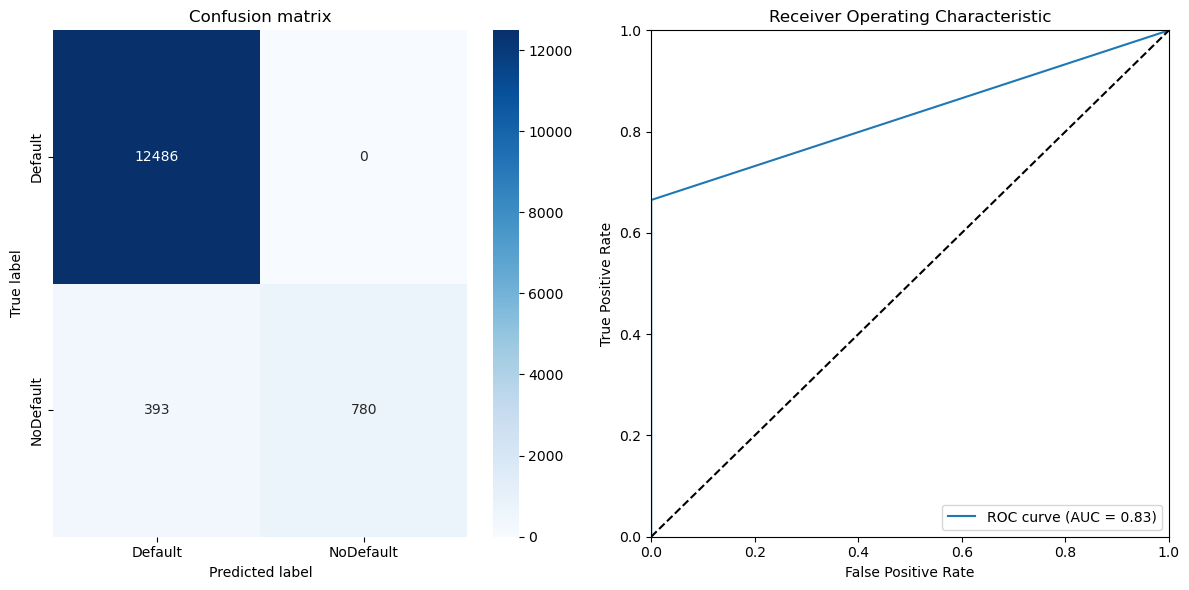

In [32]:
# defining y_pred for visualization
y_pred_rf = model_rf.predict(X_test)
# using previous defined function for visualization
plot_cm_auc(y_test, y_pred_rf, classes=['Default', 'NoDefault'])

##### AUC & f1 Score Logistic Regression:

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


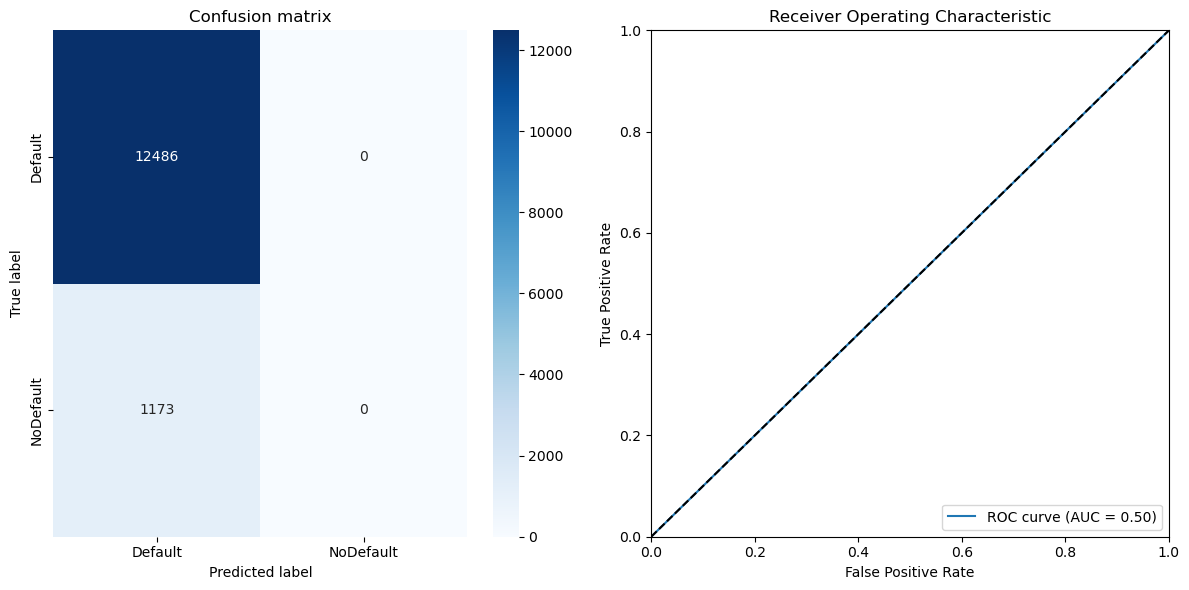

In [34]:
# defining y_pred for visualization
y_pred_lr = logreg.predict(X_test)
# using previous defined function for visualization
plot_cm_auc(y_test, y_pred_lr, classes=['Default', 'NoDefault'])

##### AUC & f1 Score KNN:

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


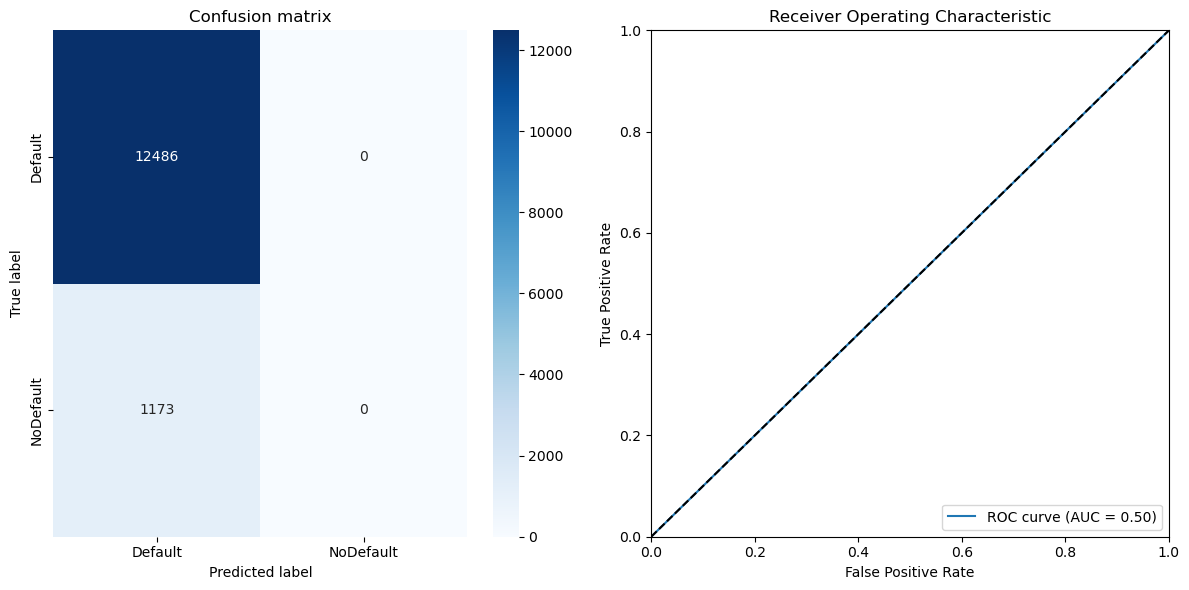

In [36]:
# defining y_pred for visualization
y_pred_knn = knn_model.predict(X_test)
# using previous defined function for visualization
plot_cm_auc(y_test, y_pred_knn, classes=['Default', 'NoDefault'])

##### AUC & f1 Gradient Boosting Classifier:

In [62]:
# defining y_pred for visualization
y_pred_gbc = gbc_model.predict(X_test)
# using previous defined function for visualization
plot_cm_auc(y_test, y_pred_gbc, classes=['Default', 'NoDefault'])

NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### **Hyperparameter Tunning:**

I will tune each model in the same order and go over the same process to show train and test set by using defined functions. 

#### Tunning the models 

In [39]:
# tuning Random Forest model
rf_model_cv = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = RandomizedSearchCV(rf_model_cv, rf_param_grid, cv=5, n_jobs=7)
rf_grid_search.fit(X_train_res, y_train_res)
rf_best_params = rf_grid_search.best_params_

In [48]:
# tunning Logistic Regression
model_lr = LogisticRegression()
lr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'max_iter': [500, 1000, 2000]
}
lr_grid_search = GridSearchCV(model_lr, lr_param_grid, cv=5, n_jobs=7)
lr_grid_search.fit(X_train_res, y_train_res)
lr_best_params = lr_grid_search.best_params_

In [49]:
# tunning KNN
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [2, 3, 4, 5],
    'weights': ['uniform', 'distance']
}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, n_jobs=7)
knn_grid_search.fit(X_train_res, y_train_res)
knn_best_params = knn_grid_search.best_params_

In [53]:
# tunning Gradient Boosting Classifier
gbc_model = GradientBoostingClassifier()
gbc_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01]
}
gbc_grid_search = RandomizedSearchCV(gbc_model, gbc_param_grid, cv=5)
gbc_grid_search.fit(X_train_res, y_train_res)
gbc_best_params = gbc_grid_search.best_params_

#### **Best Hyperparameters Found by Grid and Randomized Search For Each Model**

In [55]:
print("Random Forest:", rf_best_params)

print("Logistic Regression:", lr_best_params)

print("KNN:", knn_best_params)

print("Gradient Boosting Classifier:", gbc_best_params)

Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}
Logistic Regression: {'C': 10.0, 'max_iter': 500}
KNN: {'n_neighbors': 2, 'weights': 'uniform'}
Gradient Boosting Classifier: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}


#### Evaluating Hyperparameter Tuning and Comparing Metrics

In [56]:
# defining model Random Forest Classifier object
rf2 = RandomForestClassifier(n_estimators= 100, min_samples_split= 2, max_depth= None, random_state=246)
# fitting model to data 
model_rf2 = rf2.fit(X_train_res, y_train_res)
# defining model Logistic Regression
logreg2 = LogisticRegression(random_state=246, max_iter=500, C=10)
# fitting the data to the model
model_logreg2 = logreg2.fit(X_train_res, y_train_res)
# KNN Model with default hyperparameters
knn2 = KNeighborsClassifier(n_neighbors=2, weights='uniform')
# fit the data to the model and perform cross-validation
knn_model2 = knn2.fit(X_train_res, y_train_res)
# GBC with default hyperparameter
gbc2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, max_depth=7, random_state=246)
# fitting data to model 
gbc_model2 = gbc2.fit(X_train_res, y_train_res)

In [63]:
# creating lists to store the scores
train_scores_auc_cv = []
train_scores_f1_cv = []
test_scores_auc_cv = []
test_scores_f1_cv = []
#list of models
clf_models2 = [model_rf2, model_logreg2, knn_model2, gbc_model2]

# for loop to evaluate models and store both training and test scores in the list
for model in clf_models2: 
    calculate_scores(model, X_train_res, y_train_res, X_test, y_test, train_scores_auc_cv, test_scores_auc_cv, train_scores_f1_cv, test_scores_f1_cv)

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid fe

In [64]:

# Creating dataframe for metrics evaluated with default model settings
models_list_cv = ['model_rf2', 'model_logreg2', 'knn_model2', 'gbc_model2']
data_cv = {
    'model': models_list_cv,
    'train_auc': train_scores_auc_cv,
    'train_f1': train_scores_f1_cv,
    'test_auc': test_scores_auc_cv,
    'test_f1': test_scores_f1_cv
}

df_cv_metrics = pd.DataFrame(data_cv)
# Round the scores to 2 decimal places
df_cv_metrics = df_cv_metrics.round(2)

# Specify the column order
columns_cv = ['model', 'train_auc', 'train_f1', 'test_auc', 'test_f1']
df_cv_metrics = df_cv_metrics[columns_cv]

# visualize dataframe
df_cv_metrics

,model,train_auc,train_f1,test_auc,test_f1
0,model_rf2,1.00,1.00,0.86,0.97
1,model_logreg2,0.99,0.96,0.50,0.87
2,knn_model2,1.00,1.00,0.50,0.87
3,gbc_model2,1.00,1.00,0.85,0.97


In [65]:
df_metrics_default

,model,train_auc,train_f1,test_auc,test_f1
0,model_rf,1.00,1.00,0.87,0.97
1,model_logreg,0.99,0.96,0.50,0.87
2,knn_model,1.00,1.00,0.50,0.87
3,gbc_model,1.00,0.98,0.85,0.96


#### **Visualization of Models Metrics: AUC & f1 Score CV:**

##### AUC & f1 Score Random Forest Classifier CV:

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


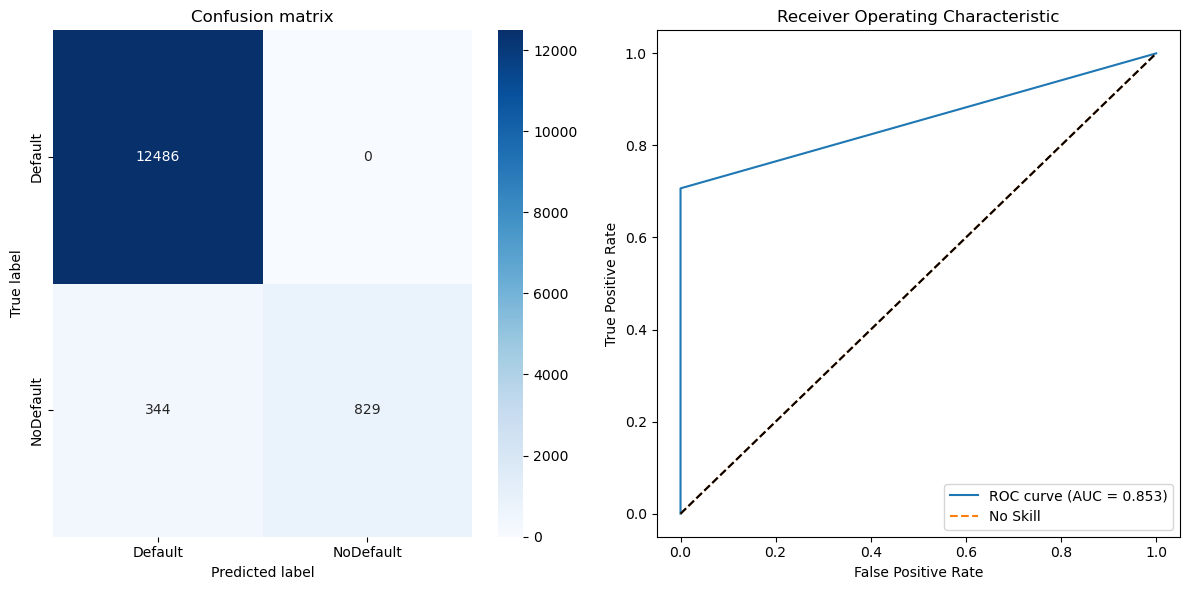

In [61]:
# defining y_pred for visualization
y_pred_rf2 = model_rf2.predict(X_test)
# using previous defined function for visualization
plot_cm_auc(y_test, y_pred_rf2, classes=['Default', 'NoDefault'])

##### AUC & f1 Score Logistic Regression CV:

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


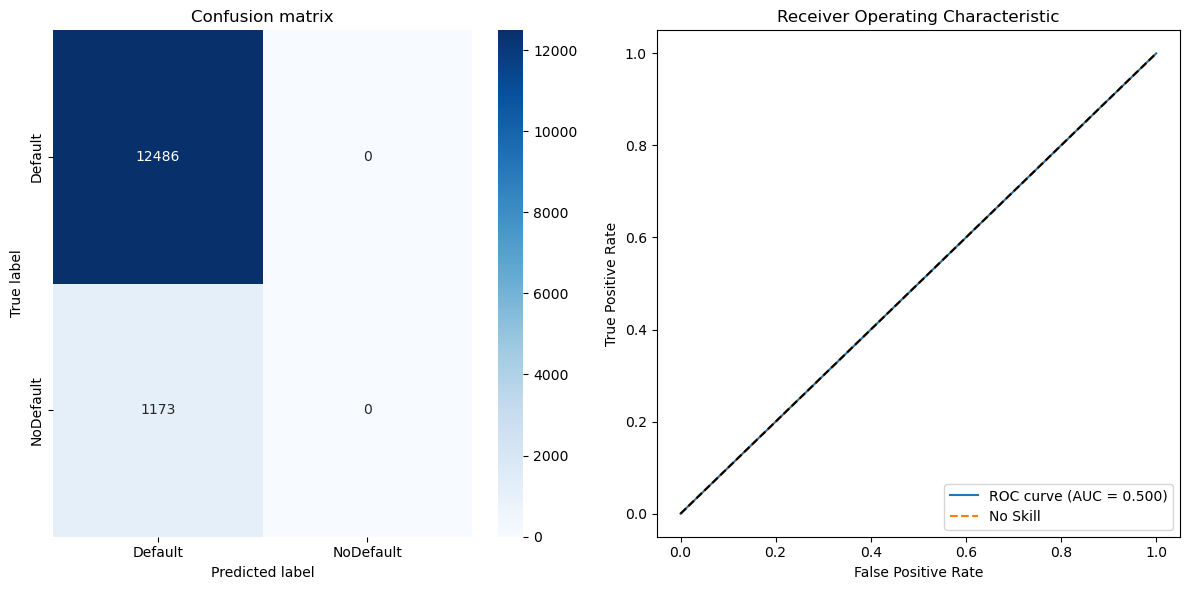

In [66]:
# defining y_pred for visualization
y_pred_lr2 = model_logreg2.predict(X_test)
# using previous defined function for visualization
plot_cm_auc(y_test, y_pred_lr2, classes=['Default', 'NoDefault'])

##### AUC & f1 Score KNN CV:

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


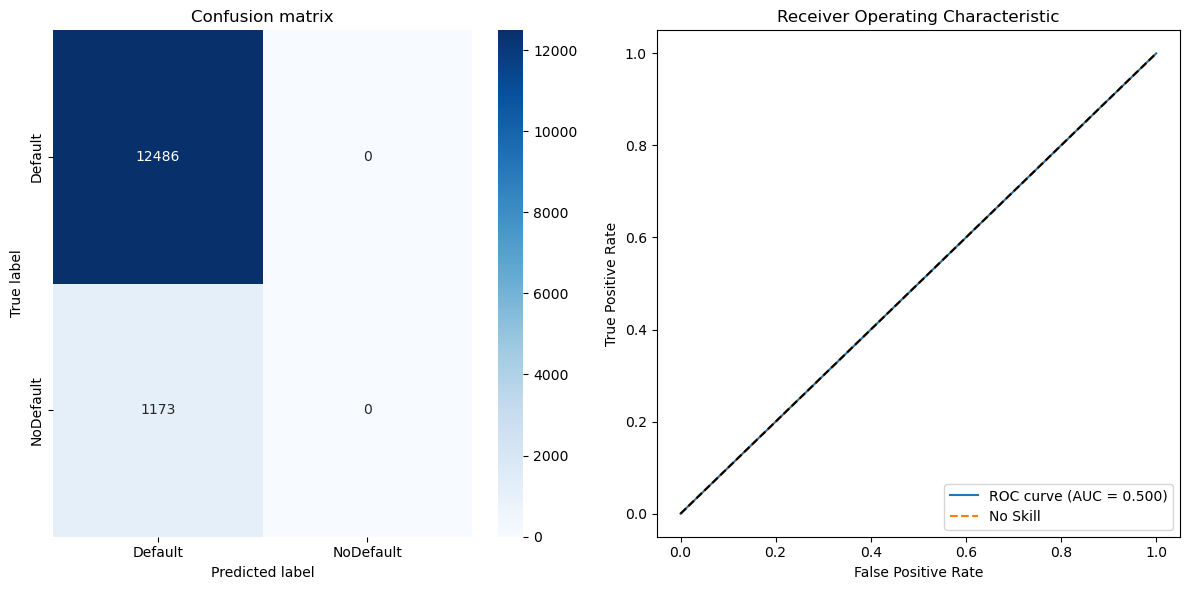

In [67]:
# defining y_pred for visualization
y_pred_knn2 = knn_model2.predict(X_test)
# using previous defined function for visualization
plot_cm_auc(y_test, y_pred_knn2, classes=['Default', 'NoDefault'])

##### AUC & f1 Score Gradient Boosting Classifier CV:

/Users/camilods16/opt/anaconda3/envs/bayes_op/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


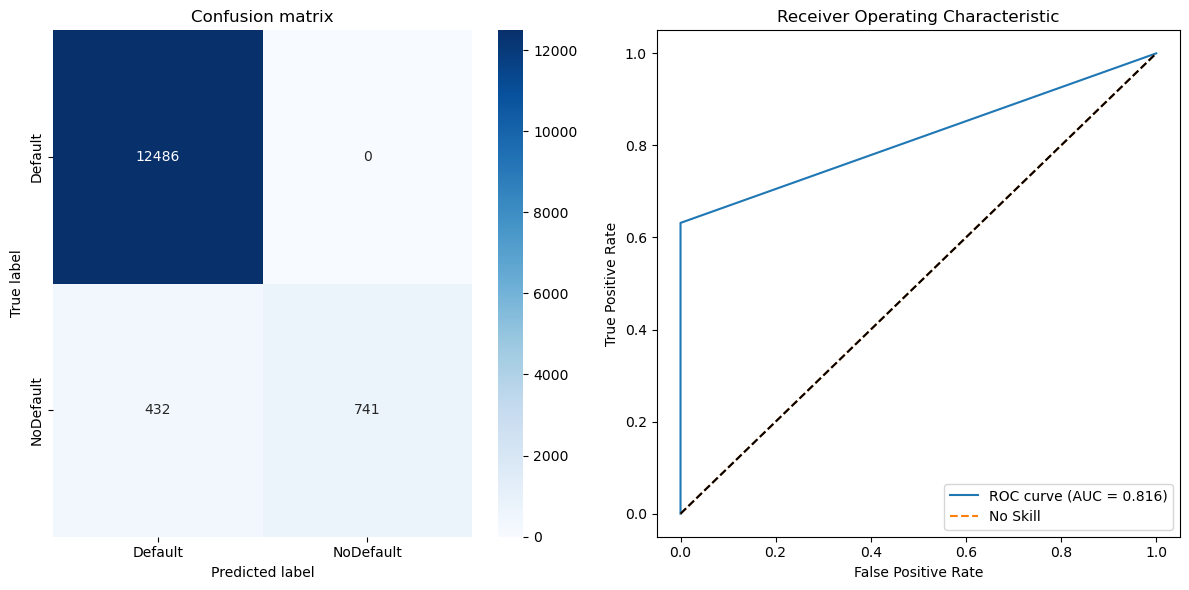

In [68]:
# defining y_pred for visualization
y_pred_gbc2 = gbc_model2.predict(X_test) 
# using previous defined function for visualization
plot_cm_auc(y_test, y_pred_gbc2, classes=['Default', 'NoDefault'])